In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.io
import glob
import os
from math import sqrt
import json
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import pathlib

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [15]:
batch_size = 16
lr = 0.001
epochs = 50

In [16]:
training_dir = 'training_vacancy/'
testing_dir = 'testing_vacancy/'
train_count=len(glob.glob(training_dir+'/**/*.jpg'))
test_count=len(glob.glob(testing_dir+'/**/*.jpg'))
print('train : {}, test : {}'.format(train_count,test_count))

train : 7584, test : 1794


In [17]:
transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [18]:
train_loader = DataLoader(
    torchvision.datasets.ImageFolder(training_dir,transform = transformer),
    batch_size = 512,
    shuffle = True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(testing_dir,transform=transformer),
    batch_size=32, shuffle=True
)

In [19]:
classes = ['vacant','non-vacant','parking']

In [20]:
class VPSNet(nn.Module):
    def __init__(self,num_classes = 3):
        super(VPSNet,self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(3, 40, kernel_size=(3, 9), stride=(1, 2)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2),
            nn.Conv2d(40, 80, kernel_size=(3, 5), padding=(1, 0)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=(1, 0)),
            nn.Conv2d(80, 120, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(120, 160, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Flatten(),
            nn.Dropout(),
            nn.Linear(160 * 5 * 5, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )
    def forward(self,x):
        x = self.model(x)
        return x

In [21]:
model = VPSNet(num_classes=3).to(device)

In [22]:
optimizer = Adam(model.parameters(),lr = lr,betas=(0.9,0.999),eps = 1e-08,weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(epochs):
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0
    
    for i,(images,labels) in enumerate(train_loader):
        
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
        optimizer.zero_grad()
        loss = loss_fn
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().data*images.size(0)
        _,prediction = torch.max(outputs.data,1)
        train_accuracy += int(torch.sum(prediction == labels.data))
    train_accuracy = train_accuracy/train_count
    train_loss = train_loss/train_count
    
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        print(images.shape)
        images=Variable(images.cuda())
        labels=Variable(labels.cuda())  
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    print('epoch : {} , train loss: {} , train accuracy : {}, test accuracy : {}'.format(epoch,train_loss,train_accuracy,test_accuracy))

In [24]:
#save or load model
#save
path = 'model_save/98_test.pth'
#path = 'model_save/98_test.pt'
#torch.save(model.state_dict(),path)
#model.save(path)
#load
model = VPSNet()
model.load_state_dict(torch.load(path))
#model = torch.load(path)

<All keys matched successfully>

torch.Size([46, 120, 3])


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [40, 3, 3, 9], but got 3-dimensional input of size [46, 120, 3] instead

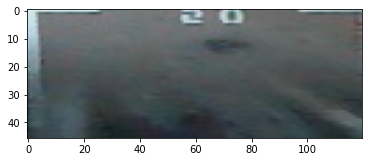

In [28]:
#visualize output
model.eval()
sample_id = 0
testing_dir = 'testing_vacancy/'
test_class = 'vacant/'

sample = cv2.imread(testing_dir+test_class+'training'+str(sample_id)+'.jpg')
plt.imshow(sample)
#sample = np.expand_dims(sample,axis = 0)
sample = torch.from_numpy(sample)
sample = Variable(sample.cuda())
print(sample.shape)
prediction = model.forward(sample)
print(prediction)